In [1]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_targets.shape

(404,)

In [6]:
test_targets.shape

(102,)

In [7]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [8]:
train_data.shape[0]

404

In [9]:
def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation=tf.nn.relu),
      layers.Dense(64, activation=tf.nn.relu),
      layers.Dense(1)
  ])
  model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
  return model

###  Validating using K-fold validation

In [10]:
k = 4
num_val_samples = train_data.shape[0] // k
num_epochs = 500
all_scores = []
for i in range(k):
  print(f"Processing fold #{i}")
  val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
      train_data[(i + 1) * num_val_samples:]],
      axis=0
  )
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
      train_targets[(i + 1) * num_val_samples:]],
      axis=0
  )
  model = build_model()
  model.fit(partial_train_data, partial_train_targets,
            epochs = num_epochs, batch_size = 16, verbose = 0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
  all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [11]:
all_scores

[2.011258602142334, 2.241483688354492, 2.5621941089630127, 2.580676794052124]

In [12]:
np.mean(all_scores)

np.float64(2.3489032983779907)

**In this case, we’re off by dollar 2,350 on average,which is significant considering that the prices range from dollar 10,000 to 50,000.**

**Let’s try training the model a bit longer: 500 epochs. To keep a record of how well
the model does at each epoch, we’ll modify the training loop to save the per-epoch
validation score log for each fold.**

### Saving the validation logs at each fold

In [14]:
num_epochs = 500
all_mae_history = []
for i in range(k):
  print(f"Processing fold #{i}")
  val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
      train_data[(i + 1) * num_val_samples:]],
      axis=0
  )
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
      train_targets[(i + 1) * num_val_samples:]],
      axis=0
  )
  model = build_model()
  history = model.fit(
      partial_train_data,
      partial_train_targets,
      validation_data=(val_data, val_targets),
      epochs = num_epochs,
      batch_size = 16,
      verbose = 0
  )
  all_mae_history.append(history.history['val_mae'])


Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


### Building the history of successive mean K-fold validation scores

In [17]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_history]) for i in range(num_epochs)
]
len(average_mae_history)

500

### Plotting validation scores

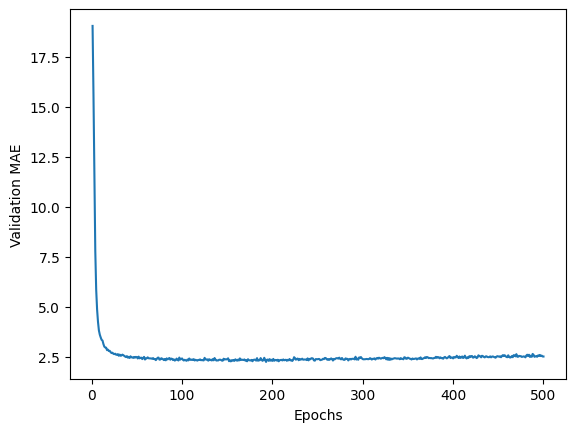

In [19]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

### Plotting validation scores, excluding the first 10 data points

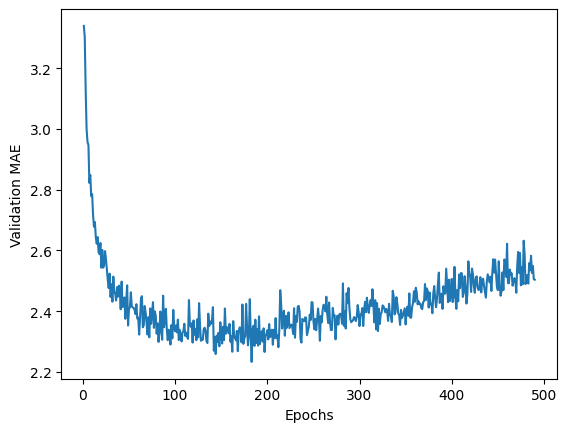

In [28]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**validation MAE stops improving significantly after
165–185 epochs (this number includes the 10 epochs we omitted). Past that point,
we start overfitting.**

### Training the final model

In [35]:
model = build_model()
model.fit(
    train_data,
    train_targets,
    epochs=175,
    batch_size=16,
    verbose=0
)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.4373 - mae: 2.1490  


In [36]:
test_mae_score

2.280405044555664

### Generating predictions on new data

In [37]:
predictions = model.predict(test_data)
predictions[0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array([7.2315288], dtype=float32)

In [39]:
test_targets[0]

np.float64(7.2)